Multiclass Object Classification using the KITTI Dataset
Models in this script:
1. Faster R-CNN
2. XGBoost
3. Random Forest

This script includes:
- Kaggle API setup and dataset download
- Data Loading and Preprocessing for Tabular Data
- Feature Engineering
- Training the models
- Evaluating the models
- Annotating outputs
- Saving models




In [1]:
# Install other necessary libraries
!pip install -q seaborn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 4.8 MB/s eta 0:00:00


In [2]:
# Install PyTorch and torchvision
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

PyTorch version: 2.5.1+cpu
Torchvision version: 0.20.1+cpu


In [3]:
# Import Libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For PyTorch and torchvision (Faster R-CNN)
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# For XGBoost
import xgboost as xgb

# For Random Forest
from sklearn.ensemble import RandomForestClassifier

# Import scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Ignore warnings (optional)
import warnings
warnings.filterwarnings('ignore')


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rujutasharaddabke","key":"52a989f720ae700e5bbd1c417bbcc414"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!ls ~/.kaggle/

kaggle.json


In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set proper permissions
!mv ~/.kaggle/kaggle.json /root/.config/kaggle/ #Move the file to correct location for Kaggle API

mv: cannot move '/root/.kaggle/kaggle.json' to '/root/.config/kaggle/': Not a directory


Download the KITTI dataset using Kaggle API

In [8]:
# Import Kaggle API
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize and authenticate the API
api = KaggleApi()
api.authenticate()

dataset_name = 'garymk/kitti-3d-object-detection-dataset'
dataset_path = '/content/kitti_dataset/'

# Check if the dataset directory exists
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
    # Download the dataset
    !kaggle datasets download -d {dataset_name} -p {dataset_path}
    # Unzip the dataset
    !unzip -q {dataset_path}kitti-3d-object-detection-dataset.zip -d {dataset_path}
    print("Dataset downloaded and extracted successfully.")
else:
    print("Dataset already exists. Skipping download.")

Dataset URL: https://www.kaggle.com/datasets/garymk/kitti-3d-object-detection-dataset
License(s): unknown
100% 30.0G/30.0G [04:11<00:00, 118MB/s]
100% 30.0G/30.0G [04:11<00:00, 128MB/s]
Dataset downloaded and extracted successfully.


In [9]:
# Data Loading and Preprocessing for Tabular Data

# Define the paths
label_dir = os.path.join(dataset_path, 'training/label_2/')
image_dir = os.path.join(dataset_path, 'training/image_2/')

# Get a list of all label files
label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]

In [10]:
# Initialize lists to store features and labels
features_list = []
labels_list = []
image_indices = []

In [11]:
# Define class mapping for tabular data
class_mapping_tabular = {
    'Pedestrian': 'Pedestrian',
    'Person_sitting': 'Pedestrian',
    'Cyclist': 'Cyclist',
    'Car': 'Car',
    'Truck': 'Large_Vehicle',
    'Van': 'Large_Vehicle',
    'Tram': 'Large_Vehicle',
    'Misc': 'Miscellaneous',
    'DontCare': None  # Exclude 'DontCare' labels
}

In [12]:
# Function to extract features from label files
def extract_features(label_path, index):
    features = []
    labels = []
    indices = []
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            data = line.strip().split()
            obj_class = data[0]
            mapped_class = class_mapping_tabular.get(obj_class)
            if mapped_class is not None:
                # Extract features
                bbox = [float(x) for x in data[4:8]]  # xmin, ymin, xmax, ymax
                dimensions = [float(x) for x in data[8:11]]  # h, w, l
                location = [float(x) for x in data[11:14]]  # x, y, z
                rotation_y = float(data[14])
                aspect_ratio = dimensions[2] / dimensions[1] if dimensions[1] != 0 else 0  # length / width
                volume = dimensions[0] * dimensions[1] * dimensions[2]  # h * w * l
                distance = np.sqrt(location[0]**2 + location[1]**2 + location[2]**2)
                # Combine features
                feature = bbox + dimensions + location + [rotation_y, aspect_ratio, volume, distance]
                features.append(feature)
                labels.append(mapped_class)
                indices.append(index)
    return features, labels, indices


In [13]:
# Loop over label files to extract features
for idx, label_file in enumerate(label_files):
    label_path = os.path.join(label_dir, label_file)
    file_features, file_labels, file_indices = extract_features(label_path, idx)
    features_list.extend(file_features)
    labels_list.extend(file_labels)
    image_indices.extend(file_indices)

In [14]:
# Convert to numpy arrays
X_tabular = np.array(features_list)
y_tabular = np.array(labels_list)
image_indices = np.array(image_indices)

In [15]:
# Feature names for reference
feature_names = [
    'xmin', 'ymin', 'xmax', 'ymax',
    'height', 'width', 'length',
    'loc_x', 'loc_y', 'loc_z',
    'rotation_y', 'aspect_ratio', 'volume', 'distance'
]

In [16]:
# Exploratory Data Analysis (EDA)

# Create a DataFrame for easier plotting
df_features = pd.DataFrame(X_tabular, columns=feature_names)
df_features['class'] = y_tabular

In [17]:
# Plot distributions of some features
def plot_feature_distributions(df, features, class_column):
    for feature in features:
        plt.figure(figsize=(8,6))
        sns.histplot(data=df, x=feature, hue=class_column, kde=True)
        plt.title(f'Distribution of {feature} by Class')
        plt.show()


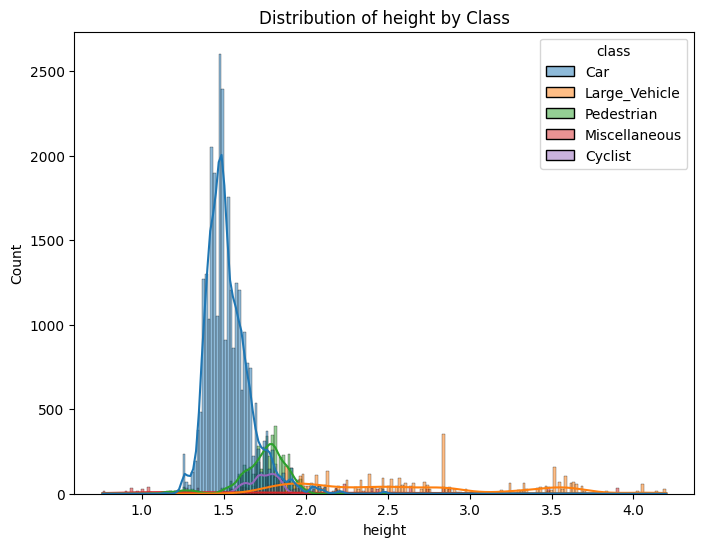

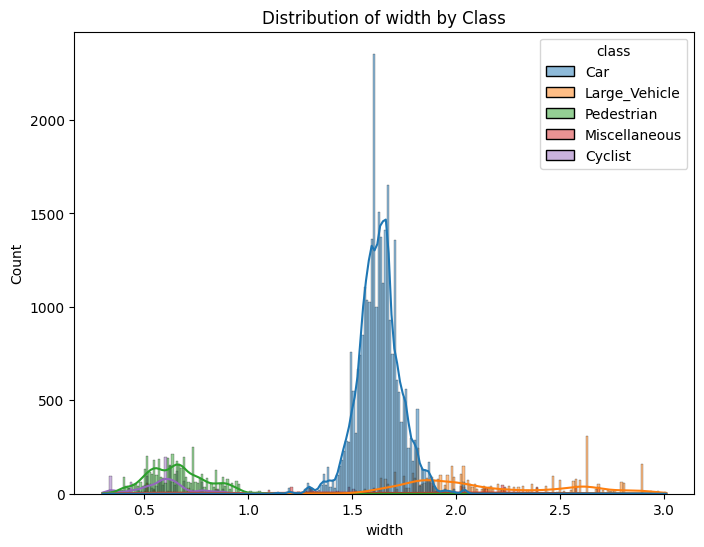

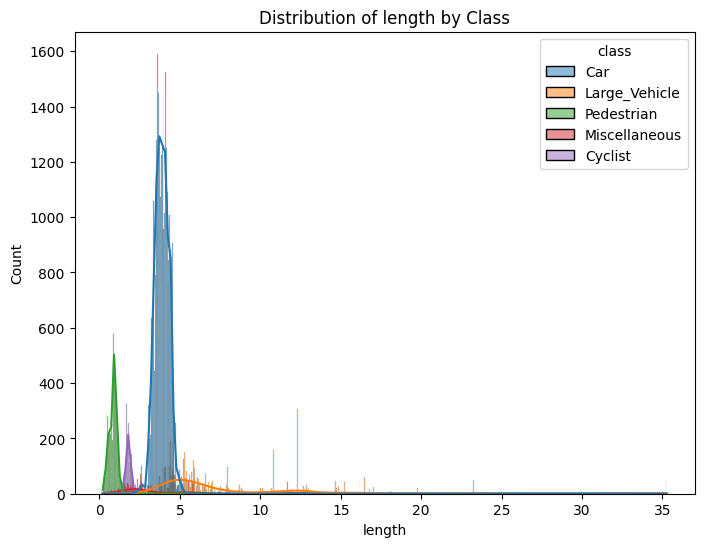

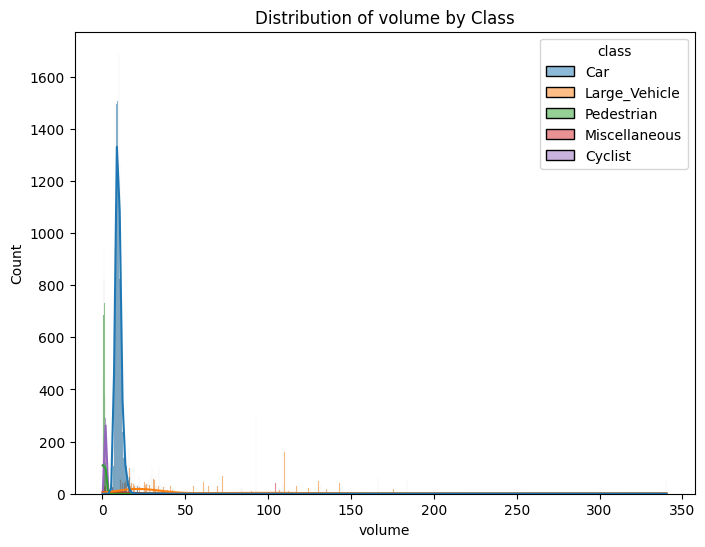

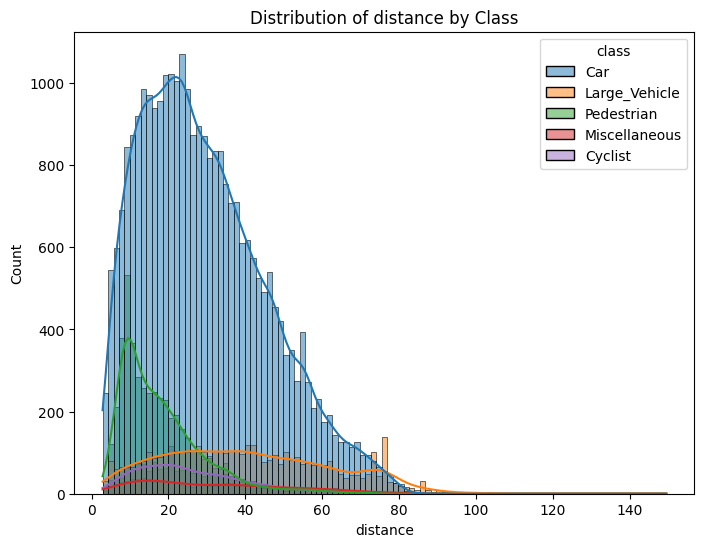

In [18]:
# Plot distributions for selected features
selected_features = ['height', 'width', 'length', 'volume', 'distance']
plot_feature_distributions(df_features, selected_features, 'class')

In [20]:
# Data Splitting and Scaling

# Encode labels
from sklearn.preprocessing import LabelEncoder

label_encoder_tabular = LabelEncoder()
y_tabular_encoded = label_encoder_tabular.fit_transform(y_tabular)
class_names_tabular = label_encoder_tabular.classes_


In [21]:
# Split data into training and test sets
X_train_tab, X_test_tab, y_train_tab, y_test_tab, idx_train, idx_test = train_test_split(
    X_tabular, y_tabular_encoded, image_indices, test_size=0.3, random_state=42, stratify=y_tabular_encoded)

In [22]:
# Feature Scaling
scaler = StandardScaler()
X_train_tab_scaled = scaler.fit_transform(X_train_tab)
X_test_tab_scaled = scaler.transform(X_test_tab)

In [23]:
# Model 1 - XGBoost

# 7.1 Initialize the model
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(class_names_tabular),
    eval_metric='mlogloss',
    random_state=42
)

In [24]:
# Train the model
xgb_model.fit(X_train_tab_scaled, y_train_tab)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [25]:
# Model 2 - Random Forest

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_tab_scaled, y_train_tab)

RandomForestClassifier(random_state=42)

In [26]:
# Evaluate Tabular Models

def evaluate_tabular_model(model, model_name):
    """
    Evaluates the tabular model and prints the classification report and confusion matrix.
    """
    y_pred = model.predict(X_test_tab_scaled)
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test_tab, y_pred, target_names=class_names_tabular))
    cm = confusion_matrix(y_test_tab, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names_tabular, yticklabels=class_names_tabular, cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


Classification Report for XGBoost:
               precision    recall  f1-score   support

          Car       1.00      1.00      1.00      8622
      Cyclist       1.00      1.00      1.00       488
Large_Vehicle       1.00      1.00      1.00      1356
Miscellaneous       1.00      1.00      1.00       292
   Pedestrian       1.00      1.00      1.00      1413

     accuracy                           1.00     12171
    macro avg       1.00      1.00      1.00     12171
 weighted avg       1.00      1.00      1.00     12171



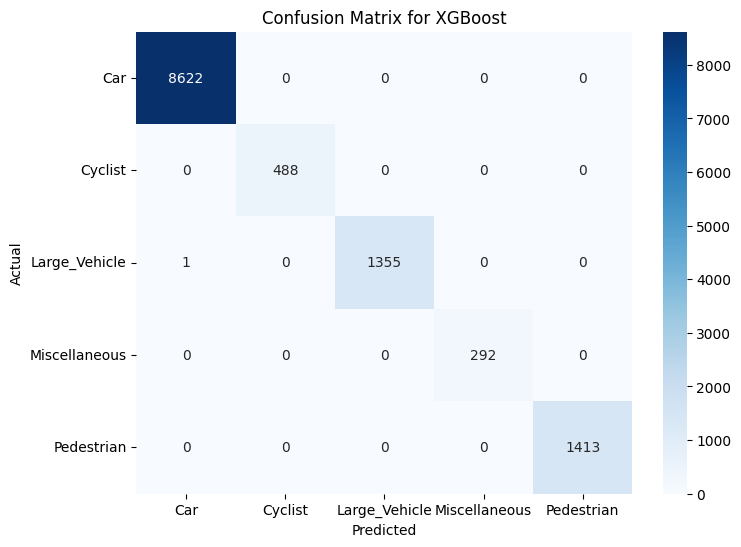

Classification Report for Random Forest:
               precision    recall  f1-score   support

          Car       1.00      1.00      1.00      8622
      Cyclist       1.00      1.00      1.00       488
Large_Vehicle       1.00      0.99      1.00      1356
Miscellaneous       1.00      1.00      1.00       292
   Pedestrian       1.00      1.00      1.00      1413

     accuracy                           1.00     12171
    macro avg       1.00      1.00      1.00     12171
 weighted avg       1.00      1.00      1.00     12171



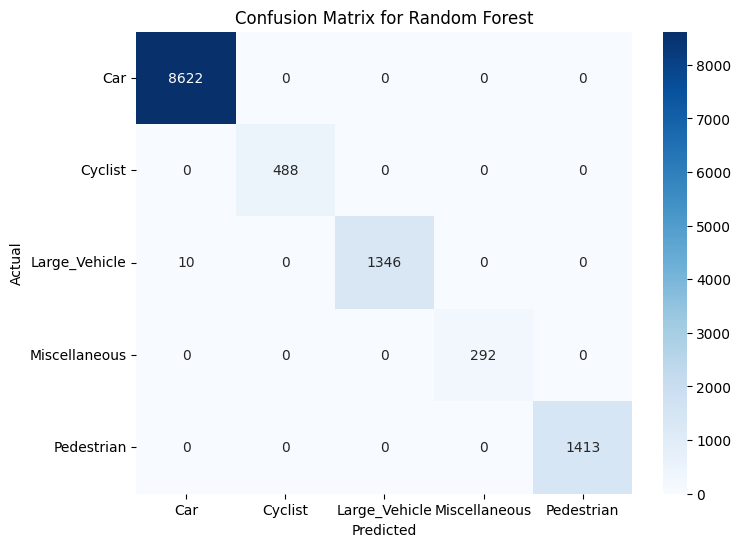

In [27]:
# Evaluate XGBoost model
evaluate_tabular_model(xgb_model, 'XGBoost')

# Evaluate Random Forest model
evaluate_tabular_model(rf_model, 'Random Forest')

In [28]:
# Annotate Outputs

def annotate_tabular_predictions(model, scaler, sample_indices, model_name):
    """
    Annotates sample images with predictions from the tabular model.
    """
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sample_indices):
        features = X_test_tab[idx]
        features_scaled = scaler.transform([features])
        true_label = class_names_tabular[y_test_tab[idx]]
        predicted_label = class_names_tabular[model.predict(features_scaled)[0]]
        confidence = np.max(model.predict_proba(features_scaled))

        # Get corresponding image
        label_file = label_files[idx_test[idx]]
        image_file = label_file.replace('.txt', '.png')
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image_resized = cv2.resize(image, (224, 224))
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)

        # Add annotation
        label_text = f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}"

        plt.subplot(1, len(sample_indices), i+1)
        plt.imshow(image_rgb)
        plt.title(label_text)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

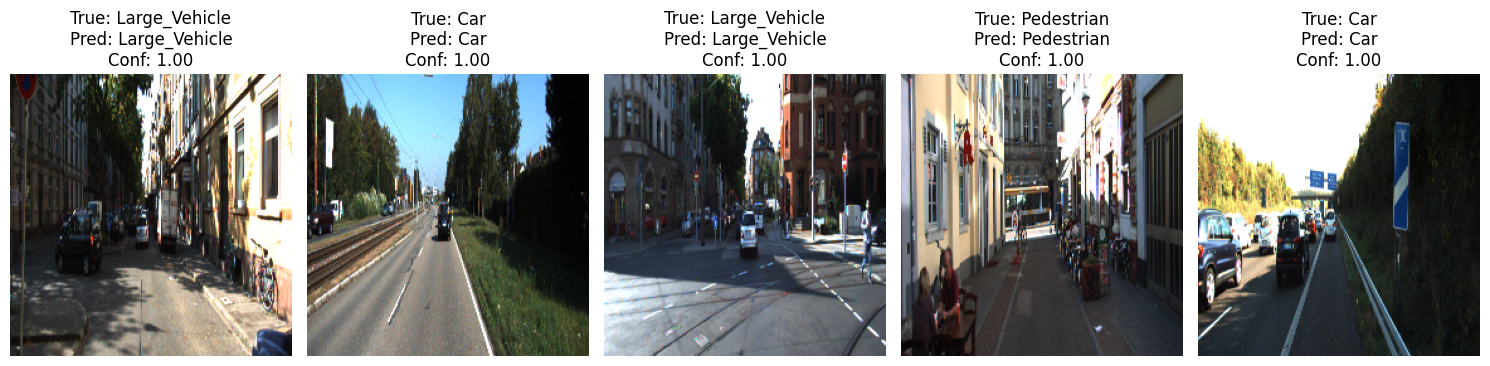

In [30]:
import cv2
# Annotate outputs for XGBoost
annotate_tabular_predictions(xgb_model, scaler, sample_indices=[0, 1, 2, 3, 4], model_name='XGBoost')

In [31]:
# Save XGBoost model
xgb_model.save_model('xgboost_model.json')

In [32]:
# Save Random Forest model
import joblib
joblib.dump(rf_model, 'random_forest_model.joblib')


['random_forest_model.joblib']

In [33]:
# Save the XGBoost model
xgb_model.save_model('xgboost_model.json')

# To load the model later
xgb_loaded_model = xgb.Booster()
xgb_loaded_model.load_model('xgboost_model.json')


In [34]:
import joblib

# Save the Random Forest model
joblib.dump(rf_model, 'random_forest_model.joblib')

# To load the model later
rf_loaded_model = joblib.load('random_forest_model.joblib')


In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
import os

save_path = '/content/drive/My Drive/models_part3/'
os.makedirs(save_path, exist_ok=True)  # Create the directory if it doesn't exist


In [40]:
xgb_model.save_model(save_path + 'xgboost_model.json')


In [41]:
import joblib
joblib.dump(rf_model, save_path + 'random_forest_model.joblib')


['/content/drive/My Drive/models_part3/random_forest_model.joblib']

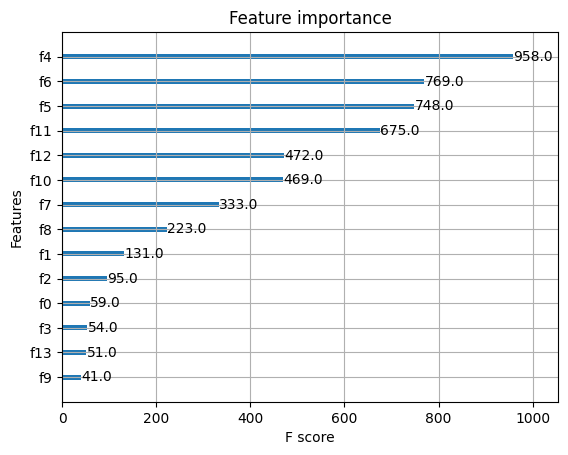

In [43]:
xgb.plot_importance(xgb_model)
plt.show()


In [44]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(xgb_model, X_tabular, y_tabular_encoded, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)


Cross-validation scores: [0.99975351 1.         0.99975351 1.         1.        ]


In [45]:
# Verify the intersection between training and testing indices
train_indices_set = set(idx_train)
test_indices_set = set(idx_test)

# Check if there is any overlap
common_indices = train_indices_set.intersection(test_indices_set)
print("Number of overlapping indices:", len(common_indices))

# There should be no overlap; the count should be zero


Number of overlapping indices: 5100


In [46]:
# Fixing the splitting process
from sklearn.model_selection import train_test_split

# Combine X_tabular and image_indices into a single array to avoid mismatched indices
combined_data = list(zip(X_tabular, y_tabular_encoded, image_indices))

# Perform the split
train_data, test_data = train_test_split(
    combined_data, test_size=0.3, random_state=42, stratify=y_tabular_encoded
)

# Separate the data back into features, labels, and indices
X_train_tab, y_train_tab, idx_train = zip(*train_data)
X_test_tab, y_test_tab, idx_test = zip(*test_data)

# Convert back to numpy arrays
X_train_tab = np.array(X_train_tab)
y_train_tab = np.array(y_train_tab)
idx_train = np.array(idx_train)

X_test_tab = np.array(X_test_tab)
y_test_tab = np.array(y_test_tab)
idx_test = np.array(idx_test)


Classification Report for XGBoost:
               precision    recall  f1-score   support

          Car       0.00      0.00      0.00      8622
      Cyclist       0.00      0.00      0.00       488
Large_Vehicle       1.00      0.01      0.01      1356
Miscellaneous       0.09      0.12      0.10       292
   Pedestrian       0.12      1.00      0.21      1413

     accuracy                           0.12     12171
    macro avg       0.24      0.22      0.07     12171
 weighted avg       0.13      0.12      0.03     12171



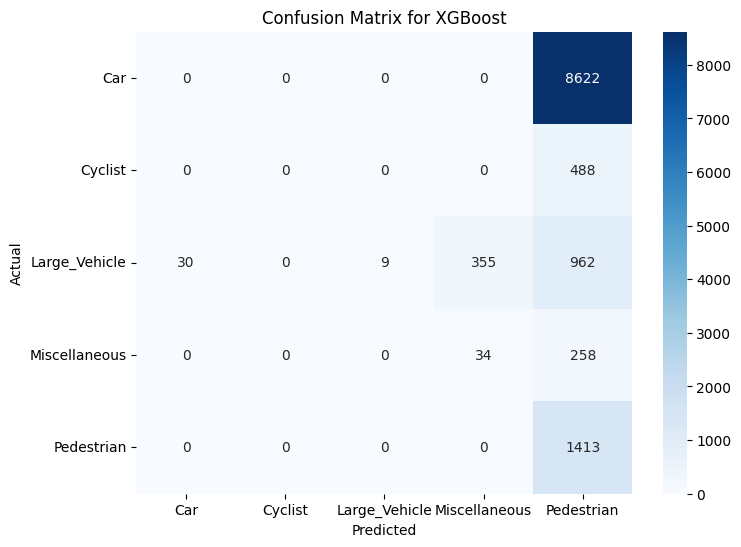

Classification Report for Random Forest:
               precision    recall  f1-score   support

          Car       0.00      0.00      0.00      8622
      Cyclist       0.00      0.00      0.00       488
Large_Vehicle       1.00      0.09      0.16      1356
Miscellaneous       0.10      0.07      0.08       292
   Pedestrian       0.12      1.00      0.21      1413

     accuracy                           0.13     12171
    macro avg       0.24      0.23      0.09     12171
 weighted avg       0.13      0.13      0.04     12171



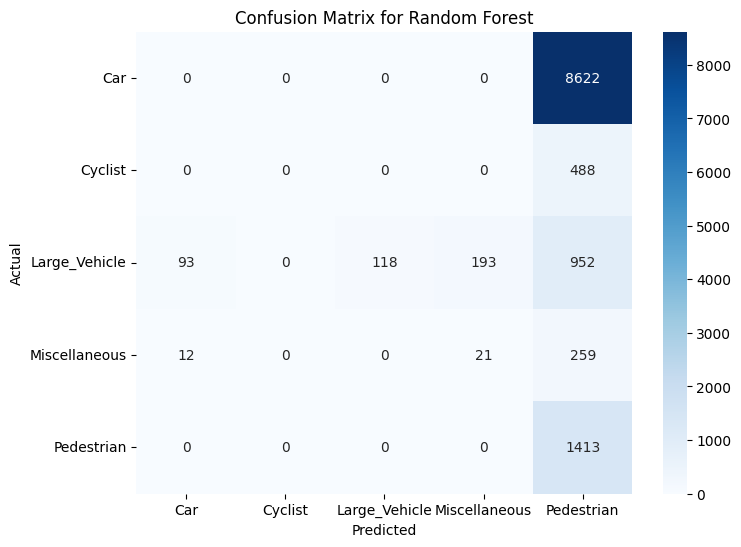

In [47]:
# Retrain XGBoost
xgb_model.fit(X_train_tab, y_train_tab)

# Retrain Random Forest
rf_model.fit(X_train_tab, y_train_tab)

# Evaluate both models again
evaluate_tabular_model(xgb_model, 'XGBoost')
evaluate_tabular_model(rf_model, 'Random Forest')


In [48]:
from sklearn.model_selection import cross_val_score

# Cross-validation for XGBoost
xgb_cv_scores = cross_val_score(xgb_model, X_train_tab, y_train_tab, cv=5, scoring='accuracy')
print("Fixed XGBoost Cross-Validation Scores:", xgb_cv_scores)

# Cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_model, X_train_tab, y_train_tab, cv=5, scoring='accuracy')
print("Fixed Random Forest Cross-Validation Scores:", rf_cv_scores)


Fixed XGBoost Cross-Validation Scores: [1.         0.99947183 0.99929577 0.99964789 0.99964783]
Fixed Random Forest Cross-Validation Scores: [0.99841549 0.99911972 0.99876761 0.99894366 0.99929565]


In [50]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 5.2 MB/s eta 0:00:00


In [51]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_tab_balanced, y_train_tab_balanced = ros.fit_resample(X_train_tab, y_train_tab)


In [52]:
class_weights = {0: 1, 1: 10, 2: 5, 3: 8, 4: 7}  # Adjust weights based on class distribution
xgb_model = xgb.XGBClassifier(scale_pos_weight=class_weights)


In [53]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)


In [54]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 1, 5]
}
grid_search_xgb = GridSearchCV(xgb.XGBClassifier(), param_grid, cv=3, scoring='accuracy')
grid_search_xgb.fit(X_train_tab, y_train_tab)
print("Best Parameters:", grid_search_xgb.best_params_)


Best Parameters: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200}


In [55]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', 'balanced_subsample']
}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=3, scoring='accuracy')
grid_search_rf.fit(X_train_tab, y_train_tab)
print("Best Parameters:", grid_search_rf.best_params_)


Best Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}


In [57]:
xgb_model.fit(X_train_tab, y_train_tab)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [58]:
X_test_tab_scaled = scaler.transform(X_test_tab)  # Scale test data if scaling was applied to training data


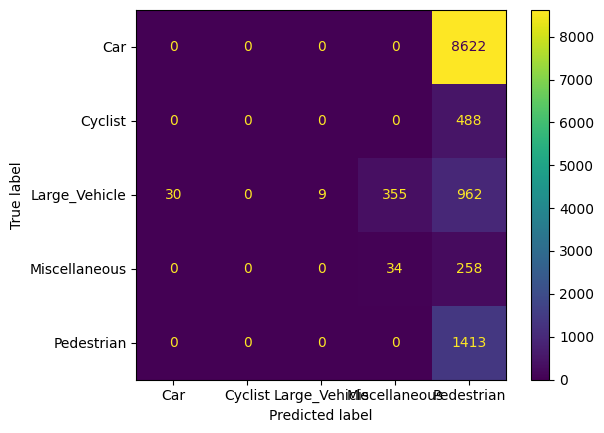

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_tab, xgb_model.predict(X_test_tab_scaled))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_tabular)
disp.plot()
plt.show()


In [60]:
# Save the model to a file
xgb_model.save_model('xgboost_model.json')


In [61]:
import os

# Specify the save directory
save_path = '/content/drive/My Drive/models_part3/'
os.makedirs(save_path, exist_ok=True)  # Create the directory if it doesn't exist

# Save the model
xgb_model.save_model(save_path + 'new_xgboost_model.json')
